In [27]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchinfo import summary
from torch import nn
from torchvision import transforms
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
from pathlib import Path

image_path = Path("./pizza_steak_sushi")
if image_path.is_dir():
    print(f"{image_path} directory exists.")

pizza_steak_sushi directory exists.


Random image path: pizza_steak_sushi/test/steak/1285886.jpg
Image class: steak
Image height: 512
Image width: 512


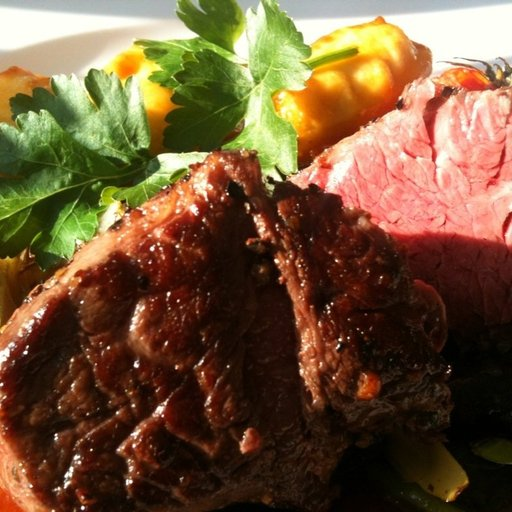

In [13]:
import random
from PIL import Image
random.seed(42)
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

####  The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


In [11]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

In [14]:
from torchvision import datasets

train_data = datasets.ImageFolder(
    root='./pizza_steak_sushi/train/', transform=manual_transforms, target_transform=None)
test_data = datasets.ImageFolder(root='./pizza_steak_sushi/test/', transform=manual_transforms)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ./pizza_steak_sushi/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ./pizza_steak_sushi/test/
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data, batch_size=32, num_workers=8, shuffle=True)
test_dataloader = DataLoader(
    dataset=test_data, batch_size=32, num_workers=8, shuffle=False)

In [16]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
weights

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/ali/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [01:26<00:00, 249kB/s]


EfficientNet_B0_Weights.IMAGENET1K_V1

In [19]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [20]:
for param in model.features.parameters():
    param.requires_grad = False

In [24]:
output_shape = 3

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = .2, inplace= True),
    torch.nn.Linear(in_features=1280,
                    out_features= output_shape,
                    bias = True)
).to(device)

In [25]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  model.eval() 

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [30]:
# Set the random seeds
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1029 | train_acc: 0.3906 | test_loss: 0.8984 | test_acc: 0.6420
Epoch: 2 | train_loss: 0.9091 | train_acc: 0.6758 | test_loss: 0.8322 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.7658 | train_acc: 0.8867 | test_loss: 0.6575 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.7509 | train_acc: 0.7070 | test_loss: 0.6041 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6222 | train_acc: 0.8867 | test_loss: 0.6315 | test_acc: 0.8561
[INFO] Total training time: 39.933 seconds


In [31]:
results

{'train_loss': [1.1029012501239777,
  0.909104086458683,
  0.7658343017101288,
  0.7508519068360329,
  0.6222302317619324],
 'train_acc': [0.390625, 0.67578125, 0.88671875, 0.70703125, 0.88671875],
 'test_loss': [0.8983619014422098,
  0.8322141965230306,
  0.6574541330337524,
  0.6040839155515035,
  0.6315216422080994],
 'test_acc': [0.6420454545454546,
  0.7443181818181818,
  0.8967803030303031,
  0.8655303030303031,
  0.8560606060606061]}

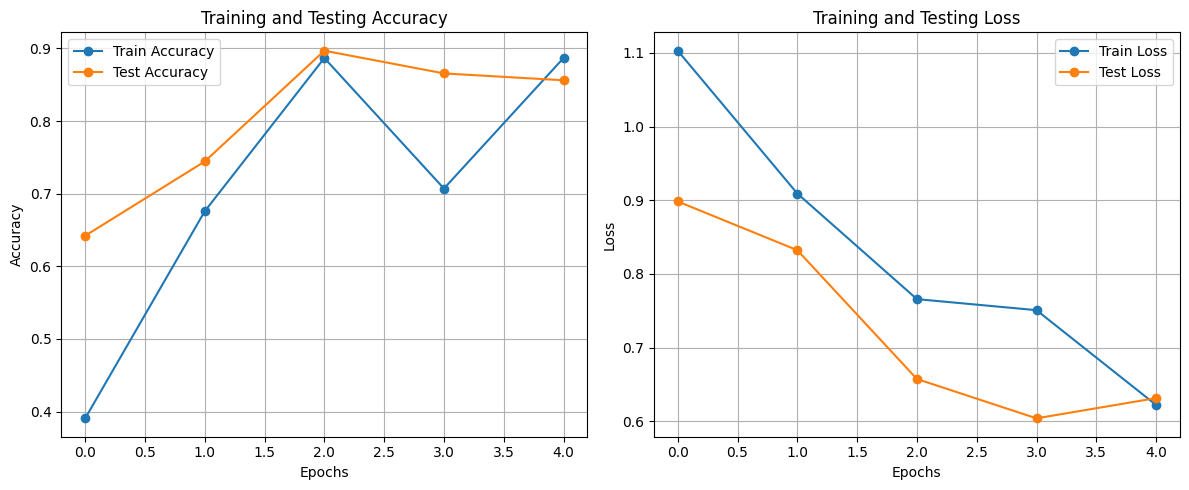

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['train_acc'], label='Train Accuracy', marker='o')
plt.plot(results['test_acc'], label='Test Accuracy', marker='o')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results['train_loss'], label='Train Loss', marker='o')
plt.plot(results['test_loss'], label='Test Loss', marker='o')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()